In [1]:
def read_file(filename):
    """
    Return (ts[], Ts[])
    """
    def parse_line(line):
        """
        Return (time, temperature).
        """
        line = line.strip()
    #     print(line)
        h = int(line[0:2])
        m = int(line[3:5])
        s = float(line[6:12])
        T = float(line[16:])
    #     print(h, m, s, T)
        return (h*60 + m)*60 + s, T

    ts = []
    Ts = []
    with open(filename, 'r') as f:
        for line in f:
            t, T = parse_line(line)
            ts.append(t)
            Ts.append(T)
    ts = [t-ts[0] for t in ts]

    print('last T:', Ts[-1])
    return ts, Ts

In [2]:
def get_T_dot(ts, Ts, avg_hw=1):
    T_dot = []
    assert len(Ts)>= 3
    for i in range(len(Ts)):
        i1 = max(i - avg_hw, 0)
        i2 = min(i + avg_hw, len(Ts)-1)

        T_d = (Ts[i2] - Ts[i1])/(ts[i2] - ts[i1])
        T_dot.append(T_d)
    return T_dot

In [3]:
import math
import numpy as np
from scipy.optimize import curve_fit
    
def fit_exp_decay(ts, ys):
    """
    Return ((y0, tau), y_fit[])
    """
    def model_func(t, y0, yf, tau):
        return (y0 - yf) * np.exp(-t/tau) + yf
    params = curve_fit(model_func, np.array(ts), np.array(ys))
    
    T_init, T_final, tau = params[0]
    print('T_init =', T_init)
    print('T_final =', T_final)
    print('tau =', tau)
    
    return params[0], [model_func(t, *params[0]) for t in ts]

def fit_decay1(ts, ys):
    """
    Return ((a, b, c, Tf), y_fit[])
    """
    def model_func(t, a, b, Tf):
        return a*(np.abs(b + t))**(-0.5) + Tf 
    params = curve_fit(model_func, np.array(ts), np.array(ys))    
    return params[0], [model_func(t, *params[0]) for t in ts]


# Test 1
感測器浸入熱水

last T: 46.34
T_init = -105.693906481
T_final = 46.2620131091
tau = 2.84535594729


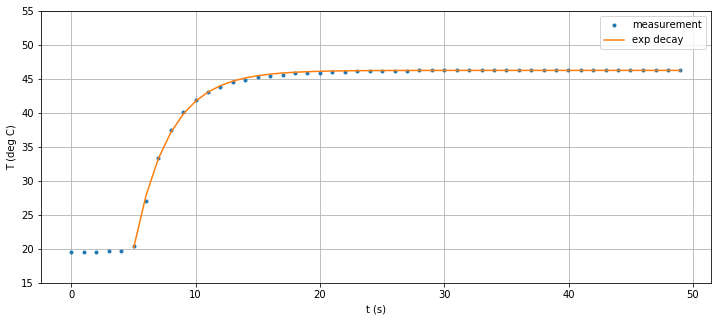

In [4]:
import math
import matplotlib.pyplot as plt

filename = 'response_test_1.txt'
ts, Ts = read_file(filename)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,1,1)

# Ys = [46.34 - 130*math.exp(-t*0.33) for t in ts]

# fit exponential decay
ts2 = ts[5:]
Ts2 = Ts[5:]
params, T_fit = fit_exp_decay(ts2, Ts2)

#
ax.plot(ts, Ts, '.', label='measurement')
ax.plot(ts2, T_fit, '-', label='exp decay')

ax.set(xlabel='t (s)', ylim=[15,55], ylabel='T (deg C)')
plt.grid()
plt.legend(loc='best')
plt.show()

**Notes.** 
+ The temperature variation is close to an exponential approach with time constant $\tau \approx 2.84\,$s.
+ An exponential approach has the property $\ T_{\rm final} = T(t) + \tau\,\dot{T}(t)$. This can be used to correct the measured $T$, in order to make the measured temperature approach faster to real temperature.

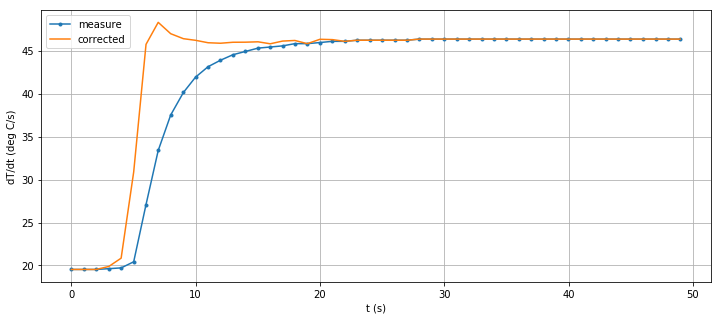

In [5]:
import math
    
avg_hw = 1
T_dot = get_T_dot(ts, Ts, avg_hw=avg_hw)      
tau = 2.84
T_corr = []
for i in range(len(Ts)):
    correction = T_dot[i]*tau if abs(T_dot[i]) >= 0.07/avg_hw else 0
    T_corr.append(Ts[i] + correction)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,1,1)
ax.plot(ts, Ts, '.-', label='measure')
ax.plot(ts, T_corr, '-', label='corrected')
ax.set(xlabel='t (s)', ylabel='dT/dt (deg C/s)')
plt.grid()
plt.legend(loc='best')
plt.show()

**Note.** The corrected $T$ is overshooting for about 4 s.

# Test 2
感測器浸入冷水

last T: 20.88
T_init = 68.9685120009
T_final = 21.0299923425
tau = 3.91999626221


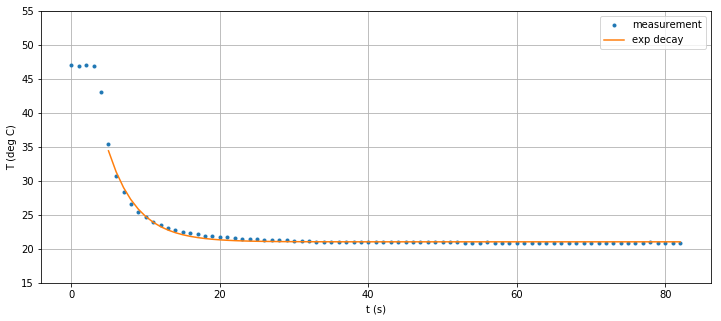

In [242]:
import math
import matplotlib.pyplot as plt

filename = 'response_test_2.txt'
ts, Ts = read_file(filename)

# fit exponential decay
ts2 = ts[5:]
Ts2 = Ts[5:]
params, T_fit = fit_exp_decay(ts2, Ts2)

#
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,1,1)

ax.plot(ts, Ts, '.', label='measurement')
ax.plot(ts2, T_fit, '-', label='exp decay')

ax.set(ylim=[15,55])
ax.set(xlabel='t (s)', ylabel='T (deg C)')
plt.grid()
plt.legend(loc='best')
plt.show()

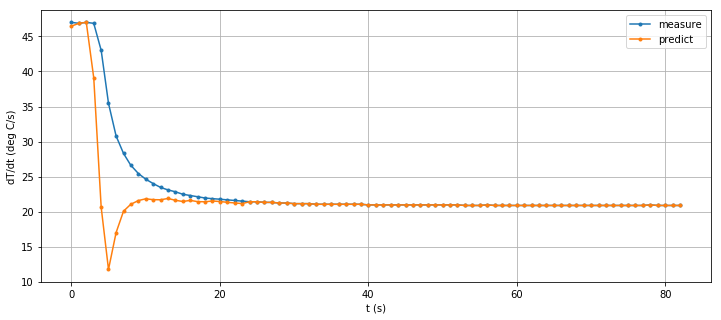

In [243]:
import math
 
avg_hw = 1
T_dot = get_T_dot(ts, Ts, avg_hw=avg_hw)  
tau = 3.9

T_pred = []
for i in range(len(Ts)):
    correction = T_dot[i]*tau if abs(T_dot[i]) >= 0.07/avg_hw else 0
    T_pred.append(Ts[i] + correction)
    
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,1,1)
ax.plot(ts, Ts, '.-', label='measure')
ax.plot(ts, T_pred, '.-', label='predict')
ax.set(xlabel='t (s)', ylabel='dT/dt (deg C/s)')
plt.grid()
plt.legend(loc='best')
plt.show()

# Test 3
感測器置冷水中，將熱水逐漸倒入

last T: 36.1


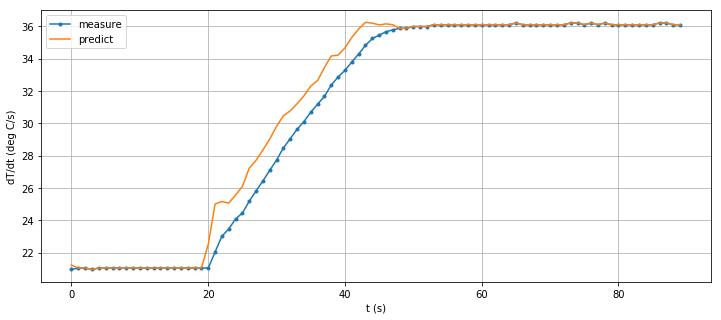

In [248]:
import math
import matplotlib.pyplot as plt

filename = 'response_test_3.txt'
ts, Ts = read_file(filename)
   
avg_hw = 1
T_dot = get_T_dot(ts, Ts, avg_hw=avg_hw)  
tau = 3

T_pred = []
for i in range(len(Ts)):
    correction = T_dot[i]*tau if abs(T_dot[i]) >= 0.07/avg_hw else 0
    T_pred.append(Ts[i] + correction)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,1,1)
ax.plot(ts, Ts, '.-', label='measure')
ax.plot(ts, T_pred, '-', label='predict')
ax.set(xlabel='t (s)', ylabel='dT/dt (deg C/s)')
plt.grid()
plt.legend(loc='best')

plt.show()

# Test 4
感測器置熱水中，將冷水逐漸倒入

last T: 21.05


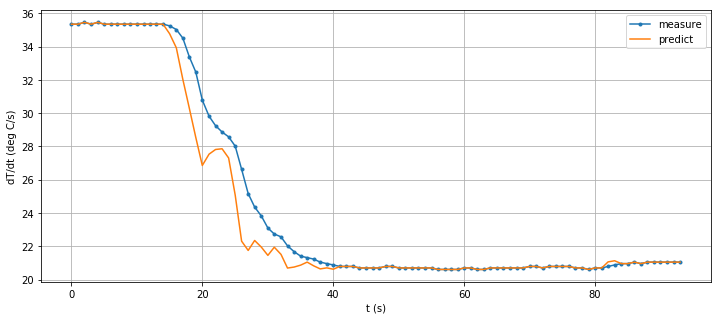

In [249]:
import math
import matplotlib.pyplot as plt

filename = 'response_test_4.txt'
ts, Ts = read_file(filename)
    
avg_hw = 1
T_dot = get_T_dot(ts, Ts, avg_hw=avg_hw)    
tau = 3

T_pred = []
for i in range(len(Ts)):
    correction = T_dot[i]*tau if abs(T_dot[i]) >= 0.07/avg_hw else 0
    T_pred.append(Ts[i] + correction)

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,1,1)
ax.plot(ts, Ts, '.-', label='measure')
ax.plot(ts, T_pred, '-', label='predict')
ax.set(xlabel='t (s)', ylabel='dT/dt (deg C/s)')
plt.grid()
plt.legend(loc='best')

plt.show()

# Test 5
感測器於空氣中冷卻

last T: 21.68
T_init = 28.4955535191
T_final = 21.4819146533
tau = 53.6991391444


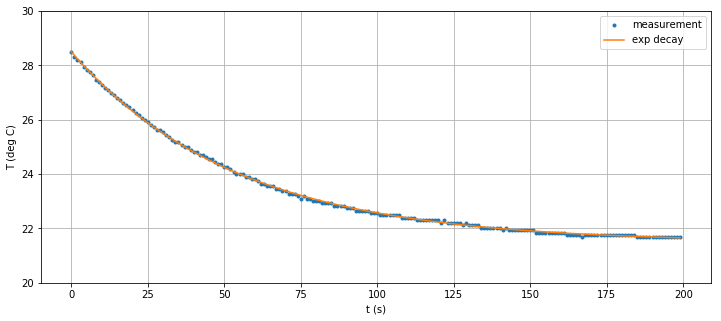

In [224]:
import math
import matplotlib.pyplot as plt

filename = 'response_test_5.txt'
ts, Ts = read_file(filename)

# fit exponential decay
ts2 = ts[0:]
Ts2 = Ts[0:]
params, T_fit = fit_exp_decay(ts2, Ts2)

#
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,1,1)

ax.plot(ts, Ts, '.', label='measurement')
ax.plot(ts2, T_fit, '-', label='exp decay')

ax.set(ylim=[20,30])
ax.set(xlabel='t (s)', ylabel='T (deg C)')
plt.grid()
plt.legend(loc='best')
plt.show()

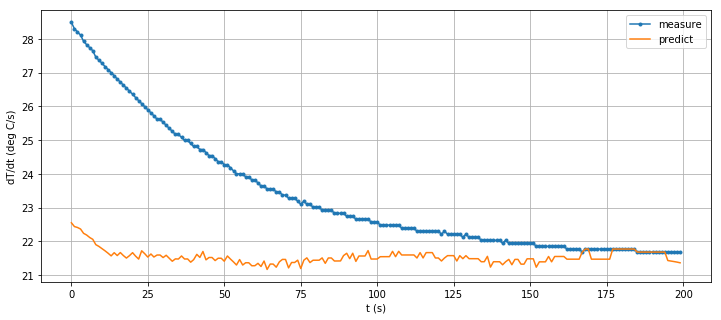

In [235]:
import math
import matplotlib.pyplot as plt

avg_hw = 15
T_dot = get_T_dot(ts, Ts, avg_hw=avg_hw)    
tau = 53

T_pred = []
for i in range(len(Ts)):
    correction = T_dot[i]*tau if abs(T_dot[i]) >= 0.07/avg_hw else 0
    T_pred.append(Ts[i] + correction)
    
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,1,1)
ax.plot(ts, Ts, '.-', label='measure')
ax.plot(ts, T_pred, '-', label='predict')
ax.set(xlabel='t (s)', ylabel='dT/dt (deg C/s)')
plt.grid()
plt.legend(loc='best')

plt.show()